# Process Video

In [1]:
import torch
import os


In [5]:
# giant model
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dinov2_vitg14

Using cache found in /work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [6]:
import requests
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )])


transform1 = transforms.Compose([
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

Using cuda!
Processing video...


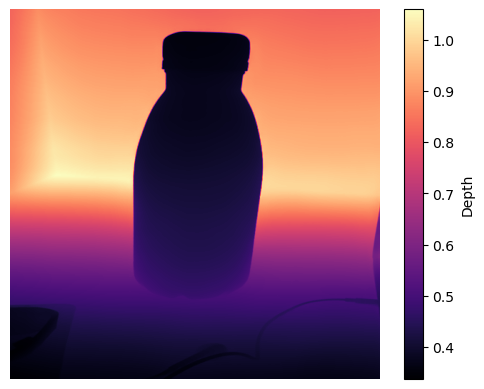

Finished processing frame 0
Finished processing frame 1
Finished processing frame 2
Finished processing frame 3
Finished processing frame 4
Finished processing frame 5
Finished processing frame 6
Finished processing frame 7
Finished processing frame 8
Finished processing frame 9
Finished processing frame 10
Finished processing frame 11
Finished processing frame 12
Finished processing frame 13
Finished processing frame 14
Finished processing frame 15
Finished processing frame 16
Finished processing frame 17
Finished processing frame 18
Finished processing frame 19
Finished processing frame 20
Finished processing frame 21
Finished processing frame 22
Finished processing frame 23
Finished processing frame 24
Finished processing frame 25
Finished processing frame 26
Finished processing frame 27
Finished processing frame 28
Finished processing frame 29
Finished processing frame 30
Finished processing frame 31
Finished processing frame 32
Finished processing frame 33
Finished processing fram

In [7]:
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt
from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation
import numpy as np

patch_size = dinov2_vitg14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
feat_dim = 1536 # vitg14

processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")

if torch.cuda.is_available():
  print('Using cuda!')
  device = torch.device("cuda")
  torch.cuda.empty_cache()
  dinov2_vitg14 = dinov2_vitg14.to(device)
  model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)
else:
  device = torch.device("cpu")

total_features  = []
total_depth_features = []

video_path = "bottle.mp4" #CHANGE FOR INPUT

cap = cv2.VideoCapture(video_path)

frame_number = 0

print("Processing video...")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = img.transpose(Image.ROTATE_270) 

    img_t = transform1(img)

    #DINOV2
    features_dict = dinov2_vitg14.forward_features(img_t.unsqueeze(0).to(device))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features.detach().cpu())


    #DEPTH PRO
    if frame_number % 5 == 0:

        inputs = processor(images=frame, return_tensors="pt").to(device)
        # Run inference
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Process the depth map
        depth_map = processor.post_process_depth_estimation(outputs, target_sizes=[(frame.shape[0], frame.shape[1])])[0]
        
        # Convert depth map to an image
        depth_tensor = depth_map["predicted_depth"]  # Extract depth tensor
        depth_array = depth_tensor.squeeze().cpu().numpy()  # Convert to NumPy array

        depth_pil = Image.fromarray(depth_array)
        depth_pil = depth_pil.transpose(Image.ROTATE_270)  # Rotate to match DINOv2 output
        depth_pil = depth_pil.resize((520, 520))  # Resize
        depth_pil = depth_pil.crop((1, 1, 519, 519))  # Center crop

        # Convert depth to tensor and normalize
        depth_transformed = transforms.ToTensor()(depth_pil).squeeze()
    
        total_depth_features.append(depth_transformed.numpy())
    else:
        total_depth_features.append(total_depth_features[-1])

    
    if frame_number == 0: # Print depth output of first frame (for debugging)
        plt.imshow(depth_transformed.numpy(), cmap="magma")  
        plt.axis("off")  # Remove axes
        plt.colorbar(label="Depth")
        plt.show()

    print("Finished processing frame", frame_number)

    frame_number+=1

cap.release() 

print("Finished processing video!")
total_features = torch.cat(total_features, dim=0)
print("total features", total_features.shape)
print("total depth features", len(total_depth_features))

num_frames = total_features.shape[0]
print('num frames:', num_frames)

## Process Foreign object

In [8]:

image_path = "duff.jpeg" #CHANGE FOR Foreign object input

frame = cv2.imread(image_path)

img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
img_t = transform1(img)

#Only run DINOv2
with torch.no_grad():
    features_dict = dinov2_vitg14.forward_features(img_t.unsqueeze(0).to(device))
    features = features_dict['x_norm_patchtokens']


#Append to the beginning of total features
features = features.detach().cpu()
total_features = torch.cat((features, total_features), dim=0)
print("New total features length:", total_features.shape)


New total features length torch.Size([232, 1369, 1536])


## PCA

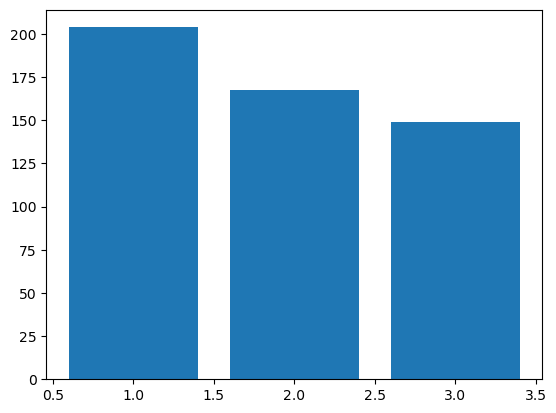

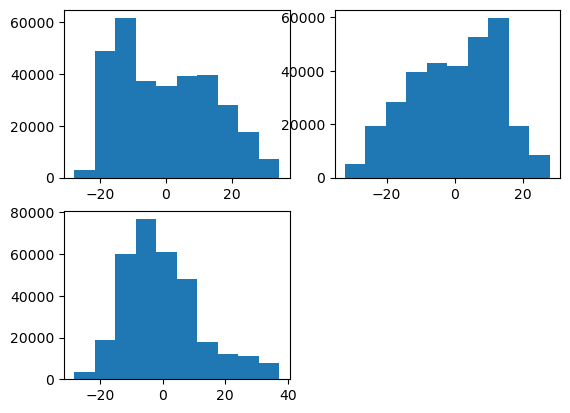

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape((num_frames+1) * patch_h * patch_w, feat_dim).cpu() #+1 for foreign image

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)


plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
plt.show()

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

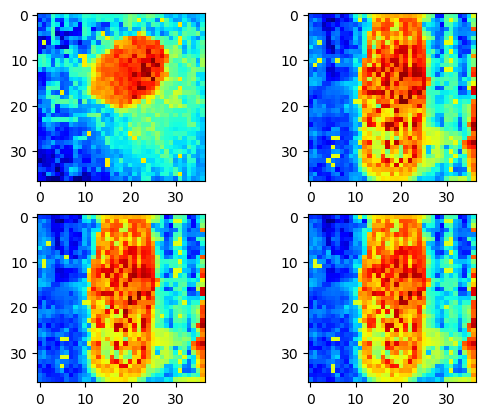

In [10]:
#FIRST COMPONENT
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())


for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w), cmap="jet")

plt.show()

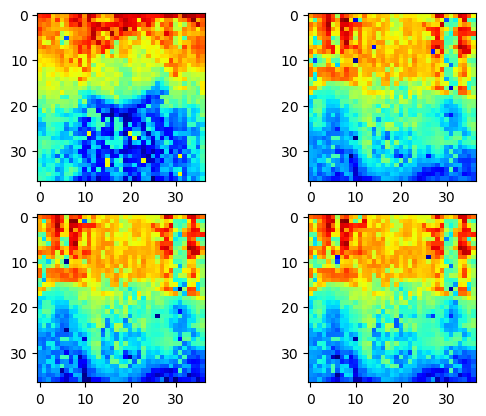

In [11]:
#SECOND COMPONENT
# min_max scale
pca_features_2nd = (pca_features[:, 1] - pca_features[:, 1].min()) / \
                     (pca_features[:, 1].max() - pca_features[:, 1].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_2nd[i*patch_h*patch_w : (i+1)*patch_h*patch_w].reshape(patch_h, patch_w), cmap="jet")

plt.show()

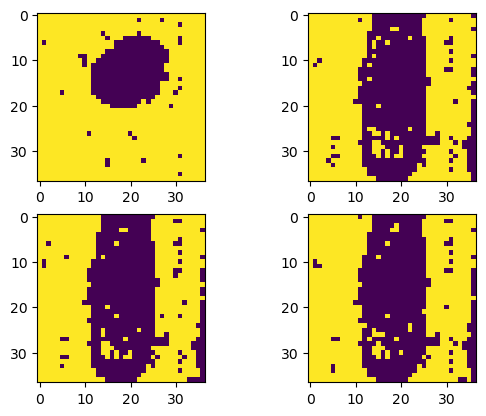

In [12]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = ~((pca_features[:, 0] >= 0.5) & (pca_features[:, 0] <= 0.9)) #CHANGE TO MASK OBJECT
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[(i) * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


(232, 37, 37, 3)


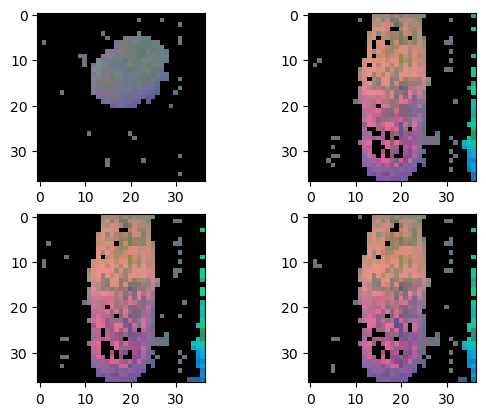

In [13]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg])
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format

pca_features_rgb = pca_features_rgb.reshape((num_frames+1), patch_h, patch_w, 3)
print(pca_features_rgb.shape)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

In [14]:
#Pop foreign frame off from pca_features 
foreign_frame = pca_features_rgb[0]
feature_map = (foreign_frame * 255).astype(np.uint8)
frame = cv2.cvtColor(feature_map, cv2.COLOR_RGB2BGR)
pca_features_rgb = pca_features_rgb[1:]
print(pca_features_rgb.shape)

(231, 37, 37, 3)


# SAM2

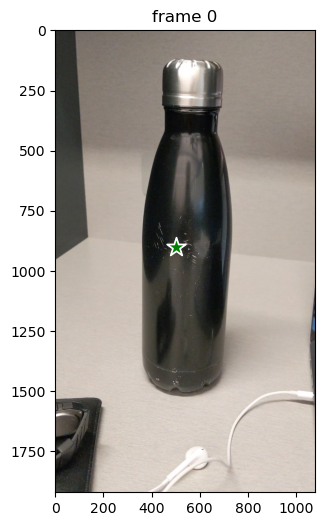

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

video_dir = "./bottle_images" #CHANGE TO INPUT VIDEO IMAGE DIRECTORY

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))


ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

#CHANGE TO SELECT OBJECT IN FIRST FRAME
points = np.array([[500, 900]], dtype=np.float32)
labels = np.array([1], np.int32)

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

ann_frame_idx = 0

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())

In [16]:
import torch
from PIL import Image
from torchvision import transforms
from sam2.sam2_video_predictor import SAM2VideoPredictor

predictor = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-large")

mask_transform = transforms.Compose([
    transforms.Resize(520),
    transforms.CenterCrop(518),  # should be multiple of model patch_size
    transforms.ToTensor()
])

inference_state = predictor.init_state(video_path=video_dir)

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    # run propagation throughout the video and collect the results in a dict
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        processed_masks = {}
        for i, out_obj_id in enumerate(out_obj_ids):
            mask = (out_mask_logits[i] > 0.0).cpu().numpy()
            mask = mask.squeeze()
    
            # Convert mask to PIL image
            mask_pil = Image.fromarray((mask*255).astype("uint8"))
    
            transformed_mask = mask_transform(mask_pil)
    
            processed_masks[out_obj_id] = transformed_mask.numpy()
            
            video_segments[out_frame_idx] = transformed_mask.numpy()

        video_segments[out_frame_idx] = processed_masks

    print("Num of retrieved masks", len(video_segments))


frame loading (JPEG): 100%|██████████| 232/232 [00:09<00:00, 24.00it/s]
/mnt/hpc/work/gz2wang/dinov2-ura/SAM2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/mnt/hpc/work/gz2wang/dinov2-ura/SAM2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 232/232 [00:09<00:00, 24.99it/s]

Num of retrieved masks 232


## SAM2 on the foreign object

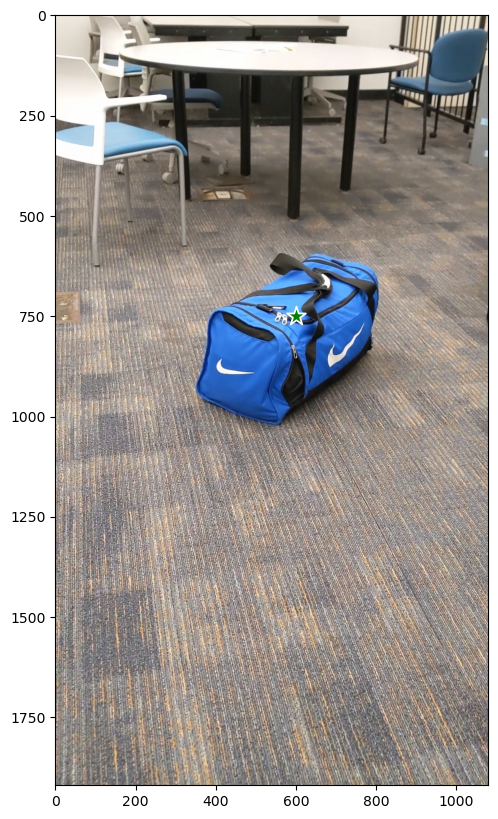

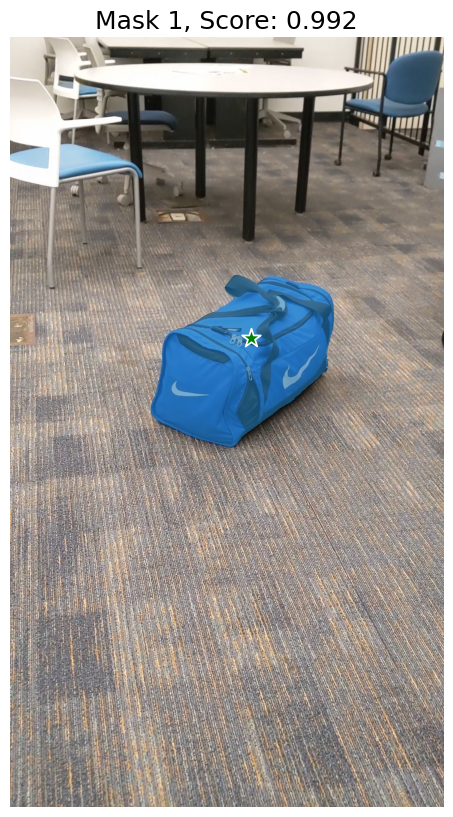

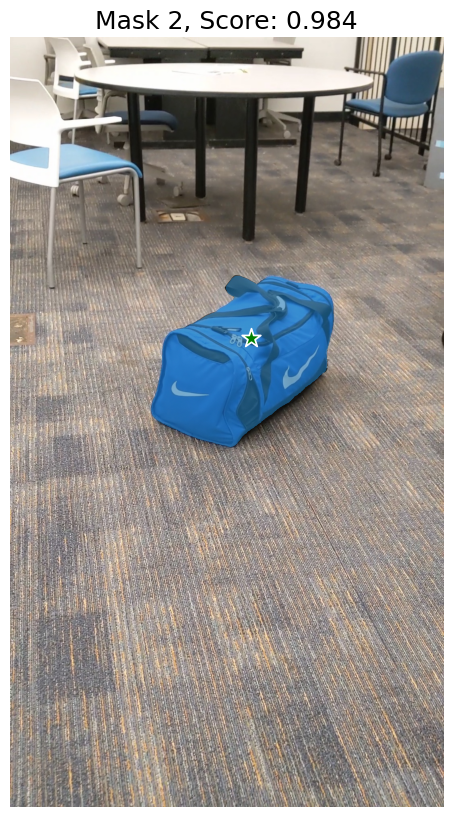

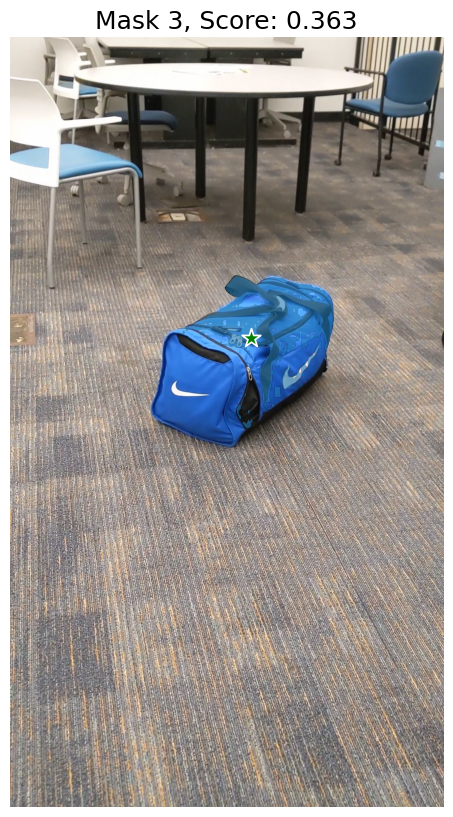

In [17]:
from sam2.sam2_image_predictor import SAM2ImagePredictor

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()


predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

image = Image.open(image_path)
image = np.array(image.convert("RGB"))

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(image)
    input_point = np.array([[600, 750]])
    input_label = np.array([1])

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.show()  

    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    
    show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

foreign_mask = masks[0] #CHANGE TO SELECT BEST MASK

# Prepare Final Animation

In [18]:
from matplotlib import cm
import numpy as np
from base64 import b64encode
from IPython.display import HTML

#clear output dir
!rm outputPNGS/*
    

def l2_distance(triple1, triple2):
    triple1 = np.array(triple1)
    triple2 = np.array(triple2)
    return np.linalg.norm(triple1 - triple2)


def find_avg_color_mask(frame, input_mask, i):

    frame = torch.tensor(frame)

    frame = frame.permute(2, 0, 1)

    input_mask = torch.tensor(input_mask)
    
    input_mask = input_mask / 255

    

    mask = input_mask.unsqueeze(0)  # Convert to shape (1, 37, 37)
    mask = mask.expand(3, -1, -1)  # Expand to (3, 37, 37) to match feature_map

    # print(frame.shape, mask.shape)
    # Apply the mask
    masked_pixels = frame * mask  # Keep only pixels inside the mask
        
    non_black_mask = (frame > 0).sum(dim=0) > 0 
    valid_mask = mask.bool() & non_black_mask.unsqueeze(0)
    
    # Count the number of selected pixels per channel
    num_pixels = valid_mask.sum(dim=(1, 2))  # Sum along height and width
    
    # Avoid division by zero
    num_pixels = torch.clamp(num_pixels, min=1)
    
    # Compute the average color per channel
    average_color = (masked_pixels*valid_mask).sum(dim=(1, 2)) / num_pixels  # Shape: (3,)

    average_color = average_color * 255
    # Convert to list (optional)
    average_color = average_color.tolist()
    
    return average_color, masked_pixels

def find_avg_depth_mask(depth_map, mask):
    depth_map = torch.tensor(depth_map)
    mask = torch.tensor(mask)

    mask = mask/255
    
    masked_depth = depth_map * mask

    num_pixels = mask.sum()

    # Avoid division by zero
    num_pixels = torch.clamp(num_pixels, min=1)
    
    # Compute the average depth
    average_depth = masked_depth.sum() / num_pixels  # Scalar

    return average_depth.item()
    

color_l2_diffs = []
item_depths = []


prev_color = (0, 0, 0)

for i in range(num_frames):
    feature_map = pca_features_rgb[i]
    # feature_map = cm.jet((feature_map - feature_map.min()) / (feature_map.max() - feature_map.min()))[:, :, :3]
    feature_map = (feature_map * 255).astype(np.uint8)
    frame = cv2.cvtColor(feature_map, cv2.COLOR_RGB2BGR)

    size = frame.shape[0]

    #Manipulate mask
    object_mask = video_segments[i][1]
    object_mask = np.squeeze(object_mask)
    resized_mask = cv2.resize(object_mask, (37, 37), interpolation=cv2.INTER_NEAREST)

    #AVG DINOv2 Color
    avg_color, masked_frame = find_avg_color_mask(frame, resized_mask, i)

    if i == 0:
        prev_color = avg_color
        
    color_diff = l2_distance(avg_color, prev_color)
    color_l2_diffs.append(color_diff)


    #Imtem depth
    item_depth = find_avg_depth_mask(total_depth_features[i], object_mask)
    item_depths.append(item_depth)


    #Save masked DINOv2 Frame
    masked_frame = masked_frame.permute(1, 2, 0).numpy()
    masked_frame = (masked_frame * 255).astype(np.uint8)

    pic = Image.fromarray(masked_frame)
    pic.save('outputPNGS/output{}.png'.format(i))

cv2.destroyAllWindows()
print('Finished!')

print("Color diff: ", len(color_l2_diffs), color_l2_diffs[0:5])
print("Item depths: ", len(item_depths), item_depths[0:5])


Finished!
Color diff:  231 [0.0, 1.5320030521052412, 0.25209910773497607, 0.9294280856806173, 1.581379549950122]
Item depths:  231 [0.4681258201599121, 0.4677034616470337, 0.4677007496356964, 0.46819570660591125, 0.46834298968315125]


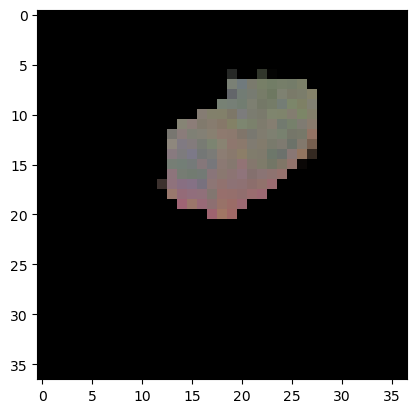

In [19]:
#Repeat masking for foreign object


color_mask = foreign_mask * 255
mask_pil = Image.fromarray(color_mask.astype("uint8"))
transformed_mask = mask_transform(mask_pil).numpy()
object_mask = np.squeeze(transformed_mask)
resized_mask = cv2.resize(object_mask, (37, 37), interpolation=cv2.INTER_NEAREST)

feature_map = (foreign_frame * 255).astype(np.uint8)
frame = cv2.cvtColor(feature_map, cv2.COLOR_RGB2BGR)

avg_color, masked_frame = find_avg_color_mask(frame, resized_mask, 0)

masked_frame = masked_frame.permute(1, 2, 0).numpy()
masked_frame = (masked_frame * 255).astype(np.uint8)

pic = Image.fromarray(masked_frame)
pic.save('foreign_object_masked.png')

plt.imshow(masked_frame)
plt.show()

foreign_diff = l2_distance(avg_color, prev_color)


In [34]:
#OPTIONAL: Save color diffs and item depths into a CSV
combined_arr = np.vstack((color_l2_diffs, item_depths))

np.savetxt("boxes.csv", combined_arr, delimiter=",", fmt="%.4f")

In [1]:
#OPTIONAL: Load color diffs and item depths from a CSV
import numpy as np

# Load the saved CSV file
retrieved_arr = np.loadtxt("duffelbag.csv", delimiter=",")

# Split the stacked array back into its original components
color_l2_diffs = retrieved_arr[0]
item_depths = retrieved_arr[1]

print("Retrieved!")

Retrieved!


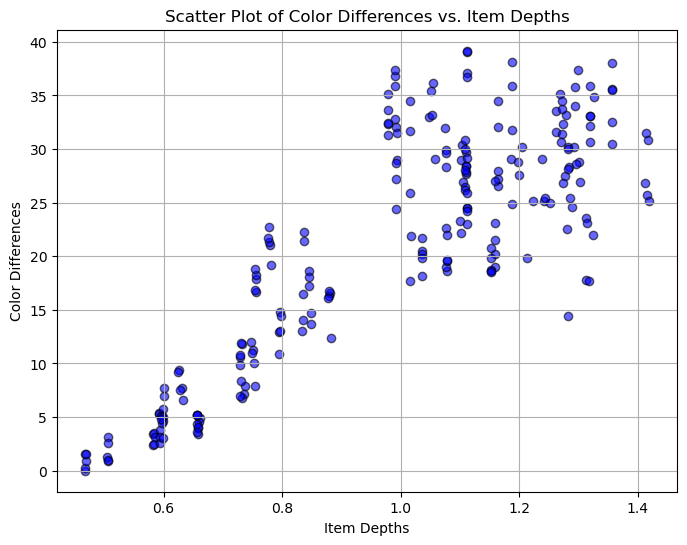

In [20]:
#OPTIONAL: Display scatter plot for color differences vs item depth

plt.figure(figsize=(8, 6))  # Set figure size
plt.scatter(item_depths, color_l2_diffs, color='b', alpha=0.6, edgecolors='k')  # Scatter plot
plt.xlabel("Item Depths")
plt.ylabel("Color Differences")
plt.title("Scatter Plot of Color Differences vs. Item Depths")
plt.grid(True)  # Show grid for better readability
plt.show()

Animation saved as animation.gif


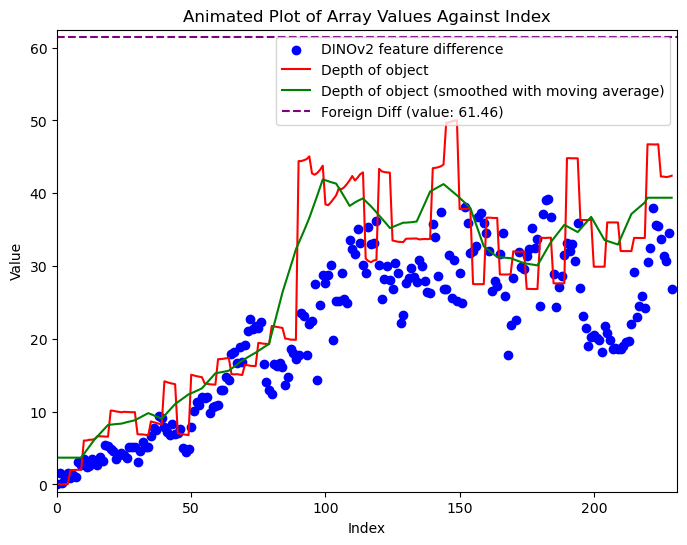

In [ ]:
#Prepare final animated graph

import matplotlib.animation as animation
import matplotlib.pyplot as plt

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def moving_average_same_length(data, window_size=5):
    smoothed = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    pad_left = (window_size - 1) // 2
    pad_right = window_size - 1 - pad_left
    return np.pad(smoothed, (pad_left, pad_right), mode='edge')


item_depth_scaling_factor = 50 #CHANGE: How much to scale item depth value so that it is displayed nicely on the graph.

item_depths_smooth = moving_average_same_length(item_depths, window_size=20)

item_depths = np.array(item_depths)
# Normalize data
normalized_depths = (item_depths - min(item_depths)) * item_depth_scaling_factor / (max(item_depths) - min(item_depths)) 
normalized_smooth_depths = (item_depths_smooth - min(item_depths)) * item_depth_scaling_factor / (max(item_depths) - min(item_depths))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, len(item_depths))
ax.set_ylim(min(normalized_depths) - 1, max(max(normalized_depths), max(color_l2_diffs), foreign_diff) + 1)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.set_title("Animated Plot of Array Values Against Index")

# Initialize elements
scatter = ax.scatter([], [], color='b', label='DINOv2 feature difference')
red_line, = ax.plot([], [], linestyle='-', color='r', label='Depth of object')
green_line, = ax.plot([], [], linestyle='-', color='g', label='Depth of object (smoothed with moving average)')

foreign_diff_line = ax.axhline(y=foreign_diff, color="purple", linestyle="--", label=f"Foreign Diff (value: {foreign_diff:.2f})")



def init():
    scatter.set_offsets(np.empty((0, 2)))
    red_line.set_data([], [])
    green_line.set_data([], [])
    return scatter, red_line, green_line, foreign_diff_line

def update(frame):
    scatter.set_offsets(np.column_stack([range(frame), color_l2_diffs[:frame]]))
    red_line.set_data(range(frame), normalized_depths[:frame])
    green_line.set_data(range(frame), normalized_smooth_depths[:frame])
    return scatter, red_line, green_line, foreign_diff_line


ax.legend(loc="upper right")  # Adjust location as needed

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(item_depths), init_func=init, blit=True, interval=50)

ani.save("animation.gif", writer="pillow", fps=30)
print("Animation saved as animation.gif")


# TESTING (CAN IGNORE)

1.803655
3.8434095


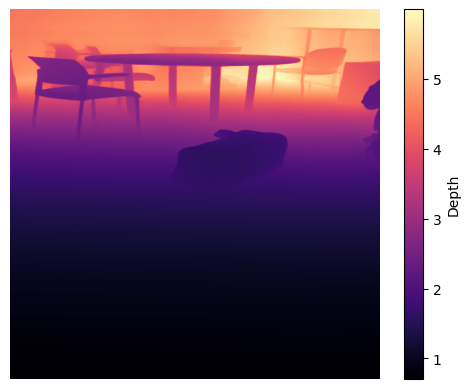

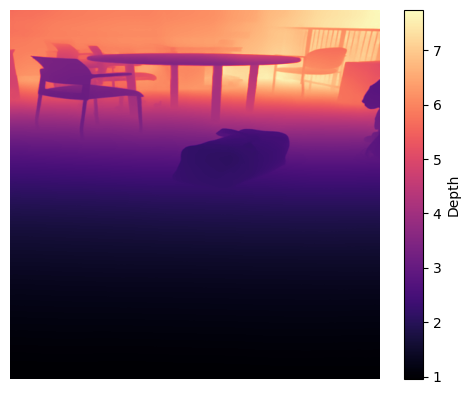

In [27]:
print(item_depths[150])
print(item_depths[155])

plt.imshow(total_depth_features[150], cmap="magma")  # Use 'magma' colormap for better depth visualization
plt.axis("off")  # Remove axes
plt.colorbar(label="Depth")
plt.show()


plt.imshow(total_depth_features[155], cmap="magma")  # Use 'magma' colormap for better depth visualization
plt.axis("off")  # Remove axes
plt.colorbar(label="Depth")
plt.show()

1080 1920
Middle 1.1395534
4.5386877 0.84508723


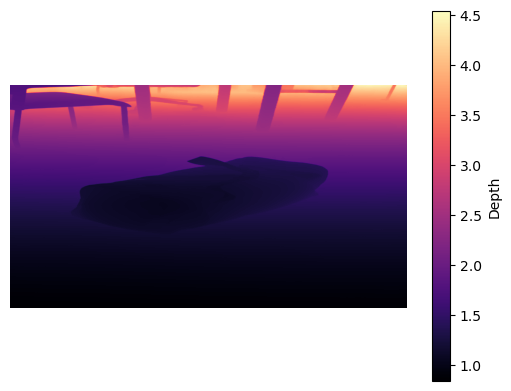

In [15]:
from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")
model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)

# Load and process image
image = Image.open("frame_0.jpg").convert("RGB")
inputs = processor(images=image, return_tensors="pt").to(device)

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Process the depth map
depth_map = processor.post_process_depth_estimation(outputs, target_sizes=[image.size])[0]

# Convert depth map to an image
depth_tensor = depth_map["predicted_depth"]  # Extract depth tensor
depth_array = depth_tensor.squeeze().cpu().numpy()  # Convert to NumPy array

print(len(depth_array), len(depth_array[0]))
print("Middle", depth_array[500][960])
print(depth_array.max(), depth_array.min())

plt.imshow(depth_array, cmap="magma")  # Use 'magma' colormap for better depth visualization
plt.axis("off")  # Remove axes
plt.colorbar(label="Depth")
plt.show()

In [10]:
import cv2

video_path = "duffelbag.mp4"  # Path to your video file
frame_number = 220  # Change to the frame index you want

cap = cv2.VideoCapture(video_path)

# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()

if ret:
    rotated_90 = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite("frame_220.jpg", rotated_90)  # Save as an image
    cv2.destroyAllWindows()
else:
    print("Failed to capture frame.")

cap.release()

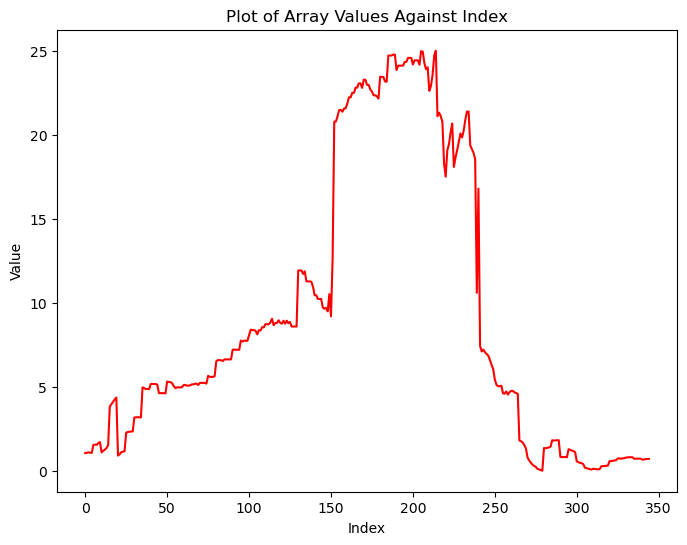

In [6]:
import numpy as np
import matplotlib.pyplot as plt

loaded_arr = np.loadtxt("duffelbag_data.csv", delimiter=",")
data = loaded_arr[1]

plt.figure(figsize=(8,6))
item_depths = np.array(data) 
plt.plot(range(len(item_depths)), (data-min(item_depths))*25/(max(item_depths)-min(item_depths)), linestyle='-', color='r')
# plt.plot(range(len(item_depths_smooth)), (item_depths_smooth-min(item_depths_smooth))*25/(max(item_depths_smooth)-min(item_depths_smooth)), linestyle='-', color='g')

# plt.plot(range(len(item_depths)), item_depths, linestyle='-', color='r')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Plot of Array Values Against Index")
plt.show()


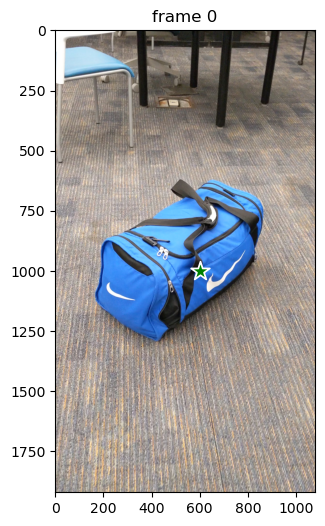

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./duffelbag_images"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))


ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

points = np.array([[600, 1000]], dtype=np.float32)
labels = np.array([1], np.int32)

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

ann_frame_idx = 0

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join('./duffelbag_images', frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
# show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 346/346 [00:13<00:00, 25.27it/s]


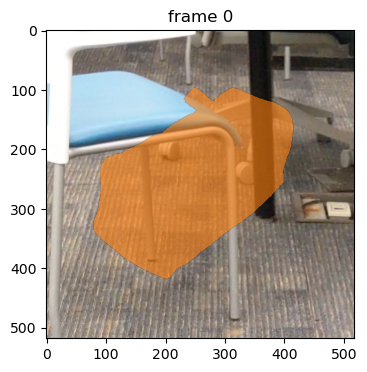

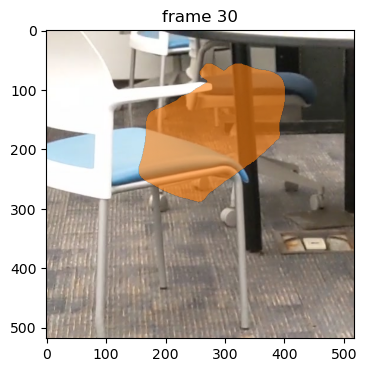

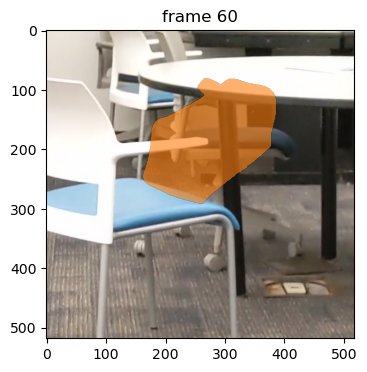

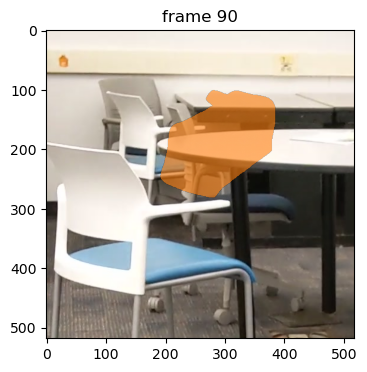

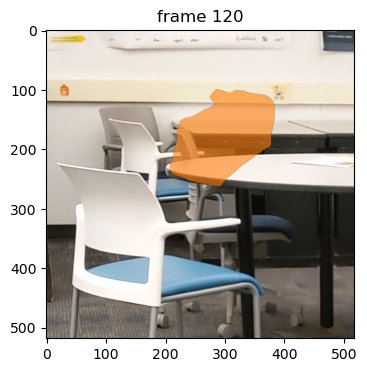

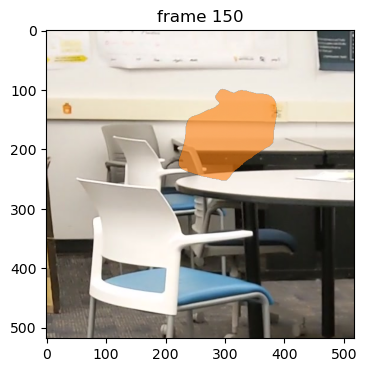

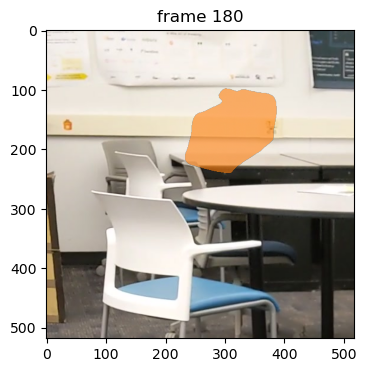

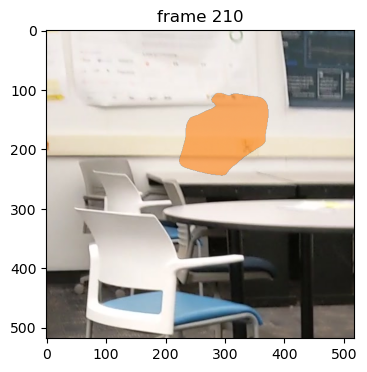

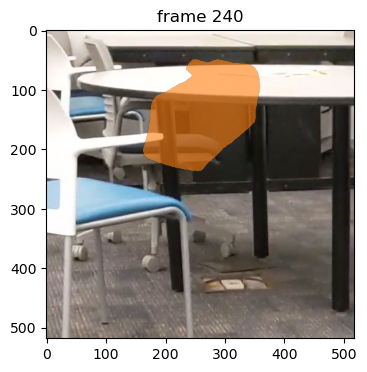

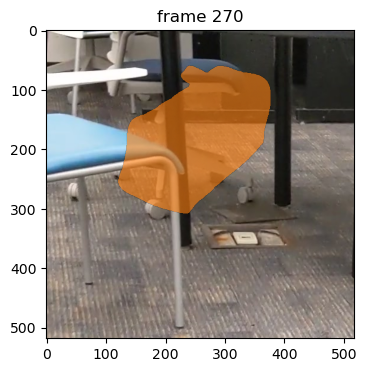

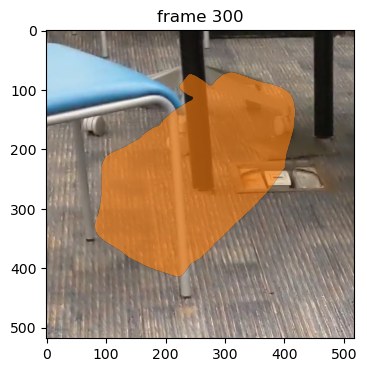

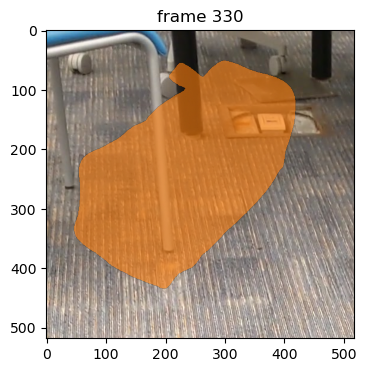

In [21]:
import torch
from PIL import Image
from torchvision import transforms
from sam2.sam2_video_predictor import SAM2VideoPredictor

predictor = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-large")

mask_transform = transforms.Compose([
    transforms.Resize(520),
    transforms.CenterCrop(518),  # should be multiple of model patch_size
    transforms.ToTensor()
])

inference_state = predictor.init_state(video_path=video_dir)

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    # run propagation throughout the video and collect the results in a dict
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        processed_masks = {}
        for i, out_obj_id in enumerate(out_obj_ids):
            mask = (out_mask_logits[i] > 0.0).cpu().numpy()
            mask = mask.squeeze()
    
            # Convert mask to PIL image
            mask_pil = Image.fromarray((mask*255).astype("uint8"))
    
            transformed_mask = transform1(mask_pil)
    
            processed_masks[out_obj_id] = transformed_mask.numpy()
            
            video_segments[out_frame_idx] = transformed_mask.numpy()

        video_segments[out_frame_idx] = processed_masks
    
    # render the segmentation results every few frames
    vis_frame_stride = 30
    plt.close("all")
    for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask > 0.5, plt.gca(), obj_id=out_obj_id)

In [28]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib.animation import FFMpegWriter

matplotlib.use('Agg')  # Use non-GUI backend

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def moving_average_same_length(data, window_size=5):
    smoothed = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    pad_left = (window_size - 1) // 2
    pad_right = window_size - 1 - pad_left
    return np.pad(smoothed, (pad_left, pad_right), mode='edge')

# Sample data
item_depths = np.random.rand(100) * 10  # Replace with actual data
color_l2_diffs = np.random.rand(100) * 5  # Replace with actual data

item_depths_smooth = moving_average_same_length(item_depths, window_size=20)

# Normalize data
normalized_depths = (item_depths - min(item_depths)) * 25 / (max(item_depths) - min(item_depths))
normalized_smooth_depths = (item_depths_smooth - min(item_depths)) * 25 / (max(item_depths) - min(item_depths))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, len(item_depths))
ax.set_ylim(min(normalized_depths) - 1, max(normalized_depths) + 1)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.set_title("Animated Plot of Array Values Against Index")

# Initialize elements
scatter = ax.scatter([], [])
red_line, = ax.plot([], [], linestyle='-', color='r')
green_line, = ax.plot([], [], linestyle='-', color='g')

def init():
    scatter.set_offsets(np.empty((0, 2)))
    red_line.set_data([], [])
    green_line.set_data([], [])
    return scatter, red_line, green_line

def update(frame):
    scatter.set_offsets(np.column_stack([range(frame), color_l2_diffs[:frame]]))
    red_line.set_data(range(frame), normalized_depths[:frame])
    green_line.set_data(range(frame), normalized_smooth_depths[:frame])
    return scatter, red_line, green_line

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(item_depths), init_func=init, blit=True, interval=50)

ani.save("animation.gif", writer="pillow", fps=30)
print("Animation saved as animation.gif")


Animation saved as animation.gif
